About the data: This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge. You can find the dataset at this link https://www.kaggle.com/puneet6060/intel-image-classification

Content

This Data contains around 25k images of size 150x150 distributed under 6 categories(Building, Forest, Glacier, Mountain, Sea, Street)










Table of content 
1. Import Libraries 
2. Image Data Preprocessing 
3. Display Images 
4. Image Augmentation 
5. Load, fit and compile pretrained models (VGG16 & Inception V3) 
6. Evaluation and compare performance

What is Transfer Learning: 

Knowledge learned from one task that is applied to another. A good example of this would be, learning how to drive a truck. Having prior knowledge of driving a car would speed up your learning curve instead of learning to drive a truck from scratch. Having already learned how to stay in one lane, steering the wheel, knowing how to gradually reduce speed instead of slamming the breaks, and also knowing all of the different driving signs/rules. This is precisely what transfer learning hopes to accomplish. 

Import Libaraies 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import os 
import zipfile 
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers 
from keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Image Data Preprocessing 

In [ ]:
local_zip = 'intel_image_class.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

base_dir = 'intel_image_class'

train_dir = os.path.join(base_dir, 'seg_train')
test_dir = os.path.join(base_dir, 'seg_test')

# Directory with our training pictures
train_buildings_dir = os.path.join(train_dir, 'buildings')
train_forest_dir = os.path.join(train_dir, 'forest')
train_glacier_dir = os.path.join(train_dir, 'glacier')
train_mountain_dir = os.path.join(train_dir, 'mountain')
train_sea_dir = os.path.join(train_dir, 'sea')
train_street_dir = os.path.join(train_dir, 'street')


# Directory with our testing pictures
test_buildings_dir = os.path.join(test_dir, 'buildings')
test_forest_dir = os.path.join(test_dir, 'forest')
test_glacier_dir = os.path.join(test_dir, 'glacier')
test_mountain_dir = os.path.join(test_dir, 'mountain')
test_sea_dir = os.path.join(test_dir, 'sea')
test_street_dir = os.path.join(test_dir, 'street')


Display Images 

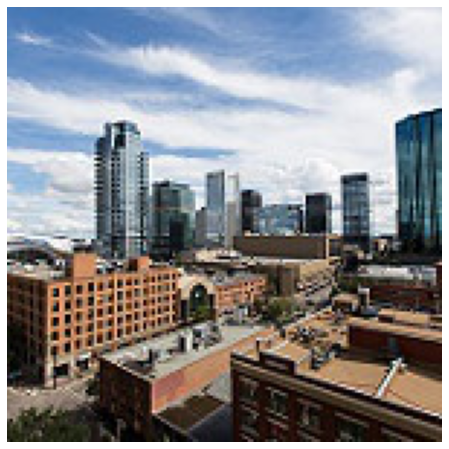

In [ ]:
plt.figure(figsize=(15, 8))
plt.axis('Off')
building_img = plt.imread('/content/intel_image_class/seg_train/buildings/10006.jpg')
plt.imshow(building_img)

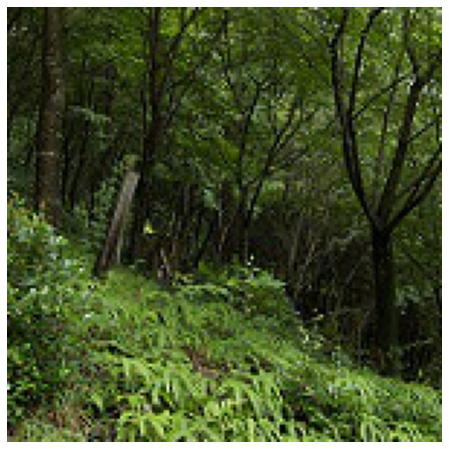

In [ ]:
plt.figure(figsize=(15, 8))
plt.axis('Off')
forest_img = plt.imread('/content/intel_image_class/seg_train/forest/10007.jpg')
plt.imshow(forest_img)

Image Augmentation

In [ ]:

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )



# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 20, 
                                                    class_mode = 'categorical', 
                                                    target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( test_dir,  
                                                        batch_size = 20, 
                                                        class_mode = 'categorical', 
                                                        target_size = (224, 224))



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Load pre-train model VGG16 

In [ ]:

v16 = VGG16(input_shape = (224, 224, 3), # VGG16 model requires input_shape to be (224,224,3)
            include_top = False, # we will additional layers and not use the final few layers so include_top = false 
            weights = 'imagenet') 

#freeze layers so that the weights don't change during backpropagation
for layer in v16.layers:
    layer.trainable = False

In [ ]:
v16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
v16.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

Compile and Fit pre-train model VGG16

In [ ]:

# Flatten the output layer to 1 dimension
x = layers.Flatten()(v16.output)
# Add a fully connected layers
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(v16.input, x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_v16 = model.fit(train_generator, validation_data = validation_generator, epochs = 5) 

Epoch 1/5
702/702 [==============================] - 205s 285ms/step - loss: 0.7076 - accuracy: 0.7411 - val_loss: 0.4362 - val_accuracy: 0.8433
Epoch 2/5
702/702 [==============================] - 194s 277ms/step - loss: 0.5512 - accuracy: 0.7937 - val_loss: 0.3973 - val_accuracy: 0.8487
Epoch 3/5
702/702 [==============================] - 195s 277ms/step - loss: 0.5184 - accuracy: 0.8074 - val_loss: 0.4304 - val_accuracy: 0.8377
Epoch 4/5
702/702 [==============================] - 194s 276ms/step - loss: 0.4835 - accuracy: 0.8189 - val_loss: 0.4213 - val_accuracy: 0.8230
Epoch 5/5
702/702 [==============================] - 193s 274ms/step - loss: 0.4610 - accuracy: 0.8281 - val_loss: 0.3431 - val_accuracy: 0.8677


Load pre-train model InceptionV3

In [ ]:

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 20, 
                                                    class_mode = 'categorical', 
                                                    target_size = (299, 299))
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                        batch_size = 20, 
                                                        class_mode = 'categorical', 
                                                        target_size = (299, 299))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:

iv3 = InceptionV3(input_shape = (299, 299, 3), 
                  include_top = False, 
                  weights = 'imagenet')

# Freeze the train layers of the InceptionV3 so that the weights don't change during backpropagation
for layer in iv3.layers:
  layer.trainable = False


In [ ]:
iv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = iv3.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
iv3_output = last_layer.output
iv3_output


last layer output shape:  (None, 17, 17, 768)


<KerasTensor: shape=(None, 17, 17, 768) dtype=float32 (created by layer 'mixed7')>

In [ ]:
iv3.input

<KerasTensor: shape=(None, 299, 299, 3) dtype=float32 (created by layer 'input_2')>

Fit and compile pre-train model InceptionV3

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(iv3_output)
# Add a fully connected layers
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(iv3.input, x)

model.compile(optimizer= RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history_iv33 = model.fit(train_generator, validation_data = validation_generator, epochs = 5)

Epoch 1/5
702/702 [==============================] - 290s 407ms/step - loss: 0.5254 - accuracy: 0.8158 - val_loss: 0.2963 - val_accuracy: 0.9037
Epoch 2/5
702/702 [==============================] - 282s 402ms/step - loss: 0.3968 - accuracy: 0.8666 - val_loss: 0.3317 - val_accuracy: 0.9000
Epoch 3/5
702/702 [==============================] - 284s 405ms/step - loss: 0.3677 - accuracy: 0.8762 - val_loss: 0.2821 - val_accuracy: 0.9137
Epoch 4/5
702/702 [==============================] - 284s 404ms/step - loss: 0.3536 - accuracy: 0.8852 - val_loss: 0.3089 - val_accuracy: 0.9097
Epoch 5/5
702/702 [==============================] - 284s 404ms/step - loss: 0.3363 - accuracy: 0.8927 - val_loss: 0.3105 - val_accuracy: 0.9160


Evaluation:

After 5 training epochs, we can see that the InceptionV3 using 'mixed7' as the last layer of the pre-train model had a validation accuracy of 91.6% and a validation loss of .3105. In contrast, VGG16 using all of its pre-trained blocks had a validation accuracy of 86.77% and a validation loss of .3431 
